# Analyse de base des fichiers éducation nationale. 
Objectif : voir les données, trouvé des pistes pour comprendre l'echec scolaire.

In [1]:
# import bibliothéques d'analyse de python
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np


In [2]:
college_resultat = pd.read_csv("donnee/fr-en-indicateurs-valeur-ajoutee-colleges.csv",sep=";")
collegue_stat = pd.read_csv("donnee/fr-en-ips-colleges-ap2022.csv",sep=";")
effectif_colleges = pd.read_csv("donnee/fr-en-college-effectifs-niveau-sexe-lv.csv",sep=";")

## Affichage des entêtes des données
Pour les écoles primaires :

In [3]:
effectif_colleges.head(1)

,rentree_scolaire,region_academique,academie,departement,commune,numero_college,denomination_principale,patronyme,secteur,rep,...,3eme_lv1_allemand,3eme_lv1_anglais,3eme_lv1_espagnol,3eme_lv1_autres,3eme_lv2_allemand,3eme_lv2_anglais,3eme_lv2_espagnol,3eme_lv2_italien,3eme_lv2_autres,code_postal
0,2019,AUVERGNE-ET-RHONE-ALPES,LYON,RHONE,VILLEURBANNE,0691664J,COLLEGE,JEAN JAURES,PUBLIC,1,...,0,175,0,0,26,0,131,14,0,69100.0


In [4]:
collegue_stat.head(1)

,rentree_scolaire,academie,code_du_departement,departement,uai,nom_de_l_etablissment,code_insee_de_la_commune,nom_de_la_commune,secteur,effectifs,ips,ecart_type_de_l_ips
0,2022-2023,LYON,001,AIN,0010002X,COLLEGE SAINT EXUPERY,01004,AMBERIEU EN BUGEY,public,686.0,95.3,34.2


In [5]:
college_resultat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622 entries, 0 to 6621
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   session                             6622 non-null   int64  
 1   uai                                 6622 non-null   object 
 2   nom_de_l_etablissement              6622 non-null   object 
 3   commune                             6622 non-null   object 
 4   departement                         6622 non-null   object 
 5   academie                            6622 non-null   object 
 6   secteur                             6622 non-null   object 
 7   nb_candidats_g                      6622 non-null   int64  
 8   taux_de_reussite_g                  6622 non-null   float64
 9   va_du_taux_de_reussite_g            6622 non-null   object 
 10  nb_candidats_p                      3126 non-null   object 
 11  taux_de_reussite_p                  3126 no

# premier nettoyage

Standariser les catègories public privé dans la colonne secteur.<br>
Standariser les rentrées scolaires<br>
Voir pour réduire le nombre de colonne des fichiers.<br>
college voir pour aggreger les classes. (langue séparé, est ce utile pour stats generale ?)<br>


In [6]:
# Les colleges de mayotte et de de guyane On des résultats inattendu selon la notice. Il ont mis ND à la place de certain taux
# Certain éléve n avait pas de trace de leur passage en 6ieme, donc Il ont une valeur ND
# Je passe ces valeur en Nan pour pouvoir travailler avec ces taux en numerique
college_resultat['taux_d_acces_6eme_3eme'].replace("ND",np.nan,inplace=True)
college_resultat['taux_d_acces_6eme_3eme'] = college_resultat['taux_d_acces_6eme_3eme'].astype('float')

In [7]:
collegue_stat['secteur'].unique()

array(['public', 'privé sous contrat'], dtype=object)

In [8]:
effectif_colleges['secteur'].unique()

array(['PUBLIC', 'PRIVE'], dtype=object)

In [9]:
# changement dans les data ecole_stat['secteur'] et college_stat['secteur']
# Les valeurs doivent être PRIVE ou PUBLIC
collegue_stat['secteur'].replace({'public':'PUBLIC','privé sous contrat':'PRIVE'},inplace=True)

In [10]:
effectif_colleges['rentree_scolaire'].unique()

array([2019, 2020, 2022, 2021])

In [11]:
collegue_stat['rentree_scolaire'].unique()

array(['2022-2023'], dtype=object)

In [12]:
# remplacer dans les données ecoles_stat et college_stat colonne rentree_scolaire 2022-2023 par 2022
collegue_stat['rentree_scolaire'].replace({'2022-2023':2022},inplace=True)

In [13]:
# création fichier college
fichier_college = pd.merge(effectif_colleges,collegue_stat,left_on=['rentree_scolaire','numero_college'],right_on=['rentree_scolaire','uai'],how='outer')

In [14]:
# supprime les colonnes en trop (doublons)
fichier_college.drop(columns=['academie_y','departement_y','secteur_y'],inplace=True)
# renomme les colonnes avec un _x
fichier_college.rename(columns={'academie_x':'academie','departement_x':'departement','secteur_x':'secteur'},inplace=True)

In [15]:
#enlevé les langues
langue = ['eme_lv1_allemand','eme_lv1_anglais','eme_lv1_espagnol','eme_lv1_autres','eme_lv2_allemand','eme_lv2_anglais','eme_lv2_espagnol','eme_lv2_italien','eme_lv2_autres']
for a in range(3,7,1):
    for b in langue:
        fichier_college.drop(columns=str(a)+b,inplace=True)


In [16]:
# enlevé les colonne commune avant le merge
college_resultat.drop(columns=['nom_de_l_etablissement','commune','departement','academie','secteur',],inplace=True)

In [17]:
fichier_college = pd.merge(fichier_college,college_resultat,left_on='numero_college',right_on='uai',how='outer')

In [18]:
fichier_college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32982 entries, 0 to 32981
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          32982 non-null  int64  
 1   region_academique                         32982 non-null  object 
 2   academie                                  32982 non-null  object 
 3   departement                               32982 non-null  object 
 4   commune                                   32982 non-null  object 
 5   numero_college                            32982 non-null  object 
 6   denomination_principale                   32982 non-null  object 
 7   patronyme                                 32927 non-null  object 
 8   secteur                                   32982 non-null  object 
 9   rep                                       32982 non-null  int64  
 10  rep_plus                          

In [19]:
fichier_college.drop(columns=['uai_x','uai_y','nom_de_la_commune','nom_de_l_etablissment','code_du_departement'],inplace=True)

## graphes France généraux école primaire :
voir l évolution des effectifs globale des effectifs au college<br>
voir la repartition dans les classes en 2022<br>

In [20]:
# style graphe :
sns.set_theme(style="whitegrid")
plt.style.use("dark_background")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [21]:
fichier_college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32982 entries, 0 to 32981
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          32982 non-null  int64  
 1   region_academique                         32982 non-null  object 
 2   academie                                  32982 non-null  object 
 3   departement                               32982 non-null  object 
 4   commune                                   32982 non-null  object 
 5   numero_college                            32982 non-null  object 
 6   denomination_principale                   32982 non-null  object 
 7   patronyme                                 32927 non-null  object 
 8   secteur                                   32982 non-null  object 
 9   rep                                       32982 non-null  int64  
 10  rep_plus                          

In [22]:
# agregation des données pour vu française

# Mettre ici les données à moyenner/autre  au lieu de sommer
dico_mean = {
    "effectifs":'mean',
    'ips':'mean',
    'ecart_type_de_l_ips':'mean',
    'taux_de_reussite_g':"mean",
    'note_a_l_ecrit_g':'mean',
    'part_presents_3eme_ordinaire_total':'mean',
    'taux_d_acces_6eme_3eme':'mean'  
}

france_college_mean = fichier_college.groupby(by='rentree_scolaire').agg(dico_mean,numeric_only=True)
for key in dico_mean:
    fichier_college.drop(columns=key,inplace=True)    

france_college = fichier_college.groupby(by='rentree_scolaire').sum(numeric_only=True)

france_college.reset_index(inplace=True)
france_college_mean.reset_index(inplace=True)
france_college = pd.merge(france_college,france_college_mean,on=['rentree_scolaire'],how='outer')

# rajout de colonne pour graphes
france_college['pourcentage_ulis_total'] = france_college['nombre_eleves_ulis']/france_college['nombre_eleves_total']*100
france_college['pourcentage_segpa_total'] = france_college['nombre_eleves_segpa']/france_college['nombre_eleves_total']*100

for classe in range(3,7,1):
    classe_total = str(classe)+"eme_total"
    classe_ulis = str(classe)+"eme_ulis"
    pourcentage_ulis = 'pourcentage_ulis_'+str(classe)+'ieme'
    france_college[pourcentage_ulis] = france_college[classe_ulis]/france_college[classe_total]*100

#économie de memoire :
del france_college_mean

valeur ajouté au collegue : resultat par rapport à la population du lycée 

In [23]:
france_college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 51 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          4 non-null      int64  
 1   rep                                       4 non-null      int64  
 2   rep_plus                                  4 non-null      int64  
 3   nombre_eleves_total                       4 non-null      int64  
 4   nombre_eleves_total_hors_segpa_hors_ulis  4 non-null      int64  
 5   nombre_eleves_segpa                       4 non-null      int64  
 6   nombre_eleves_ulis                        4 non-null      int64  
 7   6eme_total                                4 non-null      int64  
 8   6eme_hors_segpa_hors_ulis                 4 non-null      int64  
 9   6eme_segpa                                4 non-null      int64  
 10  6eme_ulis                                 

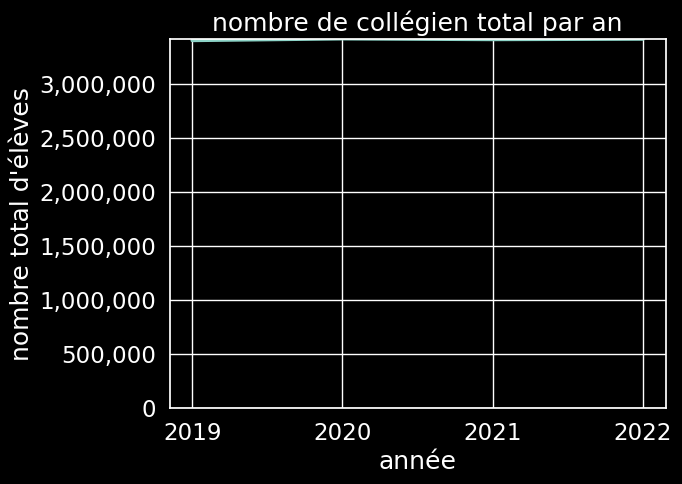

In [24]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='nombre_eleves_total',ax=ax)
ax.set_ylim(0)
ax.ticklabel_format(axis='y',style='plain')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
ax.set_title("nombre de collégien total par an")
ax.set_xlabel("année")
ax.set_ylabel("nombre total d'élèves")
plt.show()

Nous avons environ 3 millions de collegien.

In [25]:
#trouver comment avoir le nombre de classe des colleges

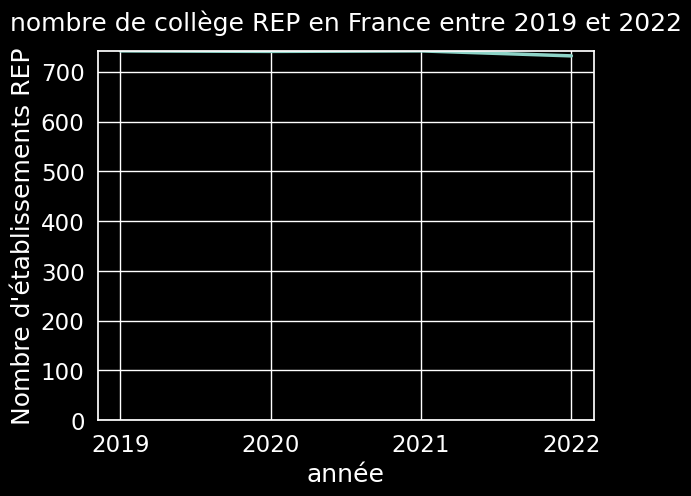

In [26]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='rep',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collège REP en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre d'établissements REP")
ax.set_ylim(0)
plt.show()

Le nombre d'etablissement en REP baisse très legèrement.

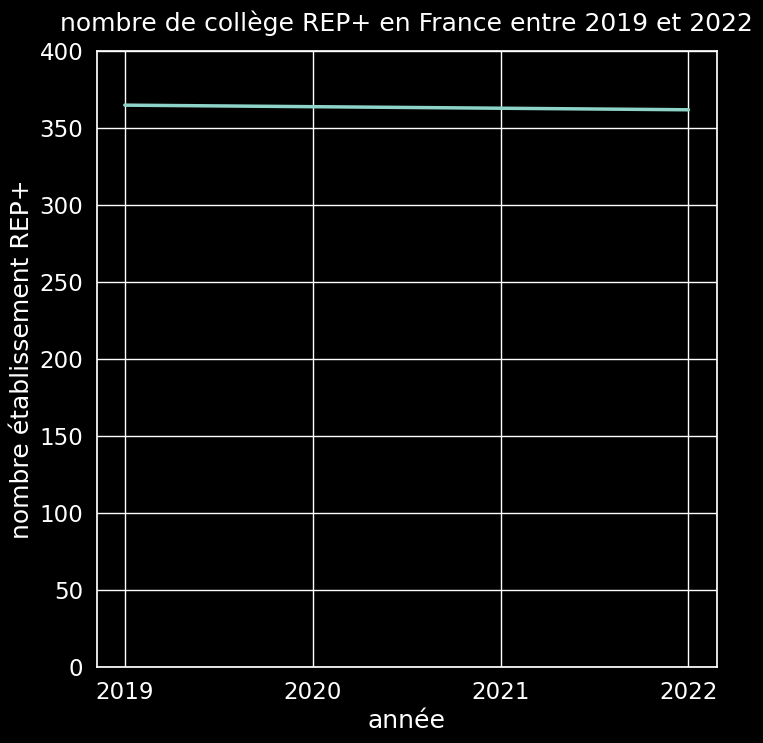

In [27]:
fig,ax = plt.subplots()
fig.set_size_inches(8,8)
sns.lineplot(data=france_college,x='rentree_scolaire',y='rep_plus',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collège REP+ en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("nombre établissement REP+")
ax.set_ylim(0,400)
plt.show()

Le nombre détablissement en REP+ est en légére baisse aussi.

In [28]:
#ulis et segpa

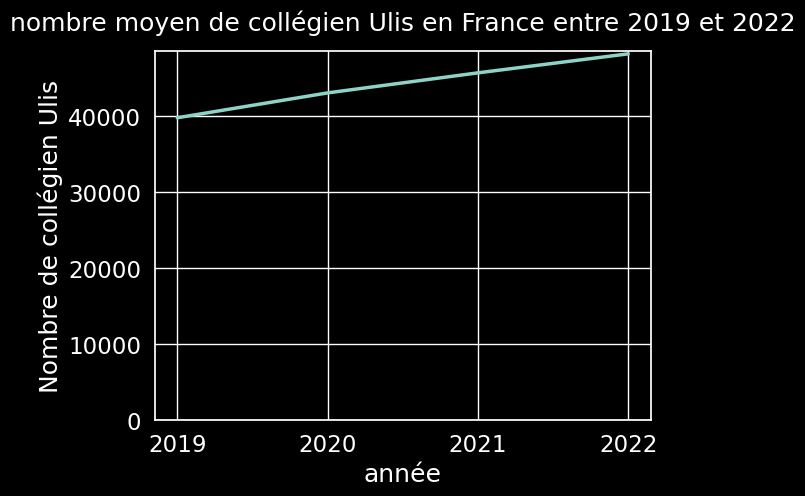

In [29]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='nombre_eleves_ulis',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre moyen de collégien Ulis en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre de collégien Ulis")
ax.set_ylim(0)
plt.show()

Augmentation des éléves Ulis au collège

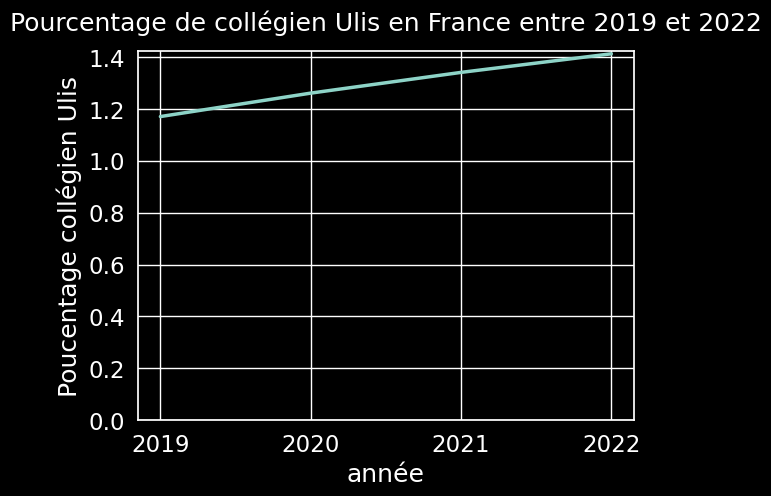

In [30]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='pourcentage_ulis_total',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Pourcentage de collégien Ulis en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Poucentage collégien Ulis")
ax.set_ylim(0)
plt.show()

On a un pourcentage de collégien Ulis en augmentation. 

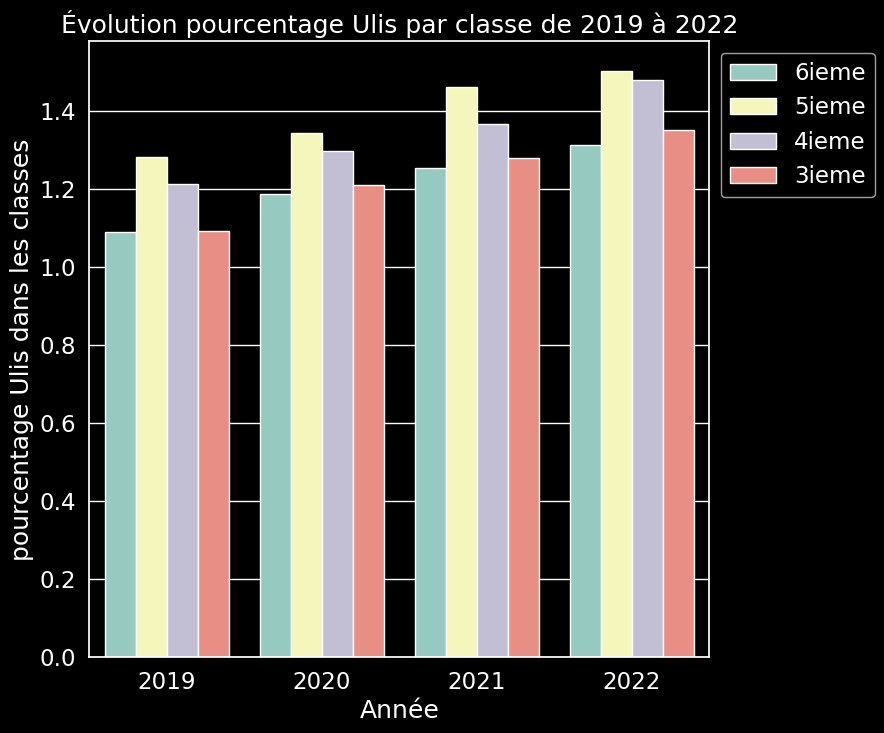

In [31]:

pourcentage_ulis_college = france_college.melt(id_vars='rentree_scolaire',
                                                value_vars=['pourcentage_ulis_6ieme','pourcentage_ulis_5ieme','pourcentage_ulis_4ieme','pourcentage_ulis_3ieme'],
                                                var_name='classe',
                                                value_name='pourcentage')

fig,ax=plt.subplots()
fig.set_size_inches(8,8)

sns.barplot(data=pourcentage_ulis_college,
            x='rentree_scolaire',
            y='pourcentage',
            hue='classe',
            ax=ax,            
            )

ax.set_title("Évolution pourcentage Ulis par classe de 2019 à 2022")
ax.set_xlabel("Année")
ax.set_ylabel("pourcentage Ulis dans les classes")

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,labels=['6ieme','5ieme','4ieme','3ieme'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()
del pourcentage_ulis_college

Les Ulis sont souvent en 5ieme et 4ieme principalement.

A savoir : On peux un enfants peut quitter le status ulis pour revenir en classe normale s'il a une bonne inclusion.Ce qui explique que les éléves ulis baisse en 3ieme. (brevet + orientation sans l´etiquette "ulis").<br>
Les changements aux colléges peuvent permettre de detecter des problémes.<br>
Il y a donc une intégration des èlèves en Ulis l'année d'après. 

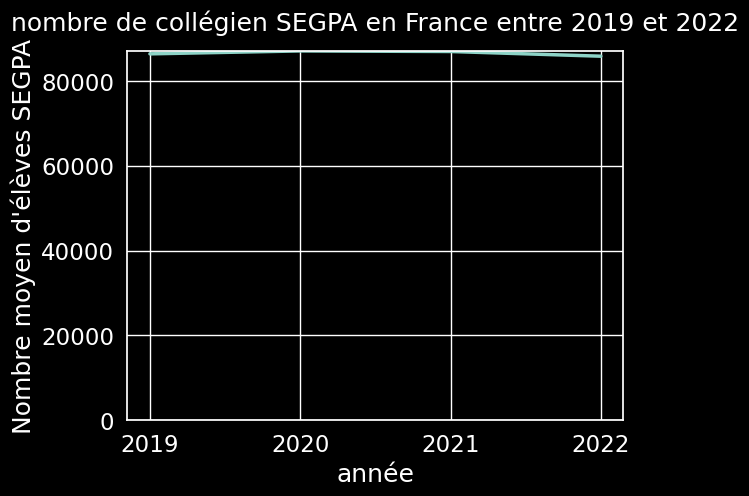

In [32]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='nombre_eleves_segpa',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collégien SEGPA en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre moyen d'élèves SEGPA")
ax.set_ylim(0)
plt.show()

Le nombre de collègien segpa reste stable avec une lègère baisse en 2022.

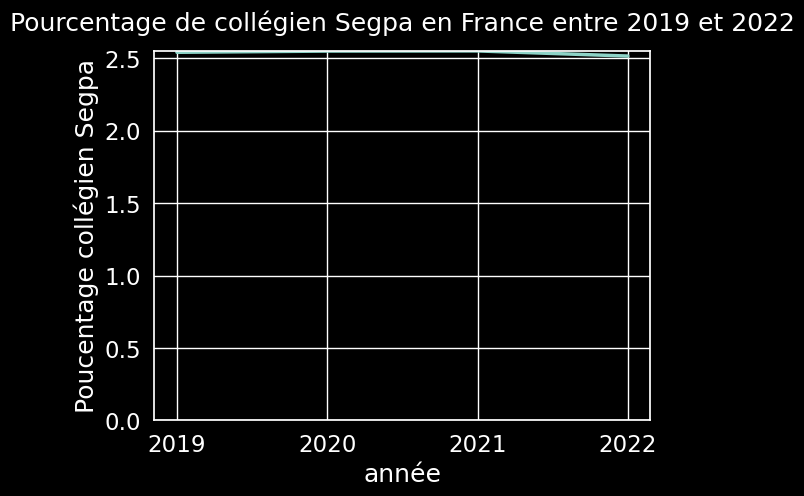

In [33]:
#SEGPA pourcentage
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='pourcentage_segpa_total',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Pourcentage de collégien Segpa en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Poucentage collégien Segpa")
ax.set_ylim(0)
plt.show()

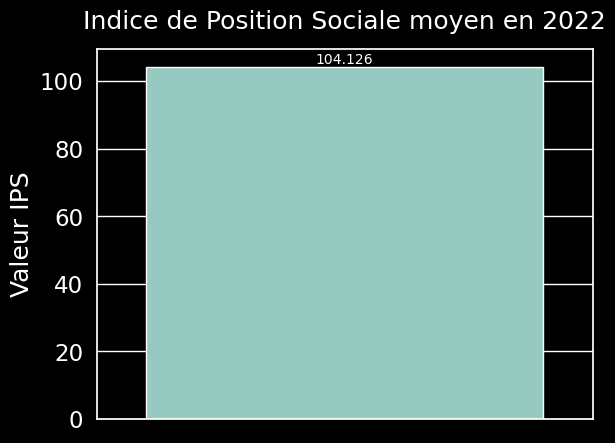

In [34]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, y="ips",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Indice de Position Sociale moyen en 2022",pad=15)
ax.set_ylabel("Valeur IPS")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

valeur de l'indice IPS (indice de position sociale): 104.126

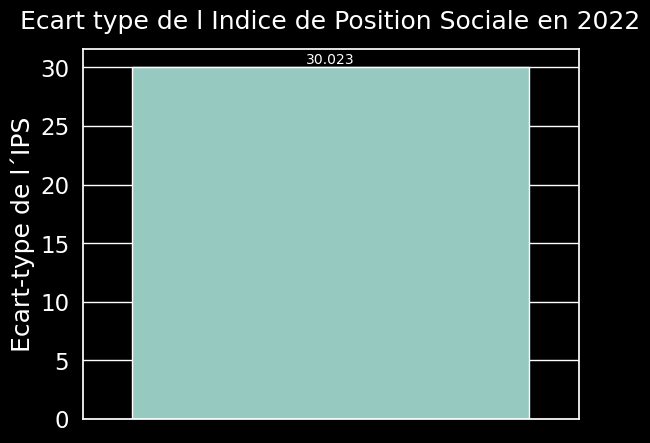

In [35]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, y="ecart_type_de_l_ips",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Ecart type de l Indice de Position Sociale en 2022",pad=15)
ax.set_ylabel("Ecart-type de l´IPS")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

Il y a un écart type moyen de l'IPS de 30

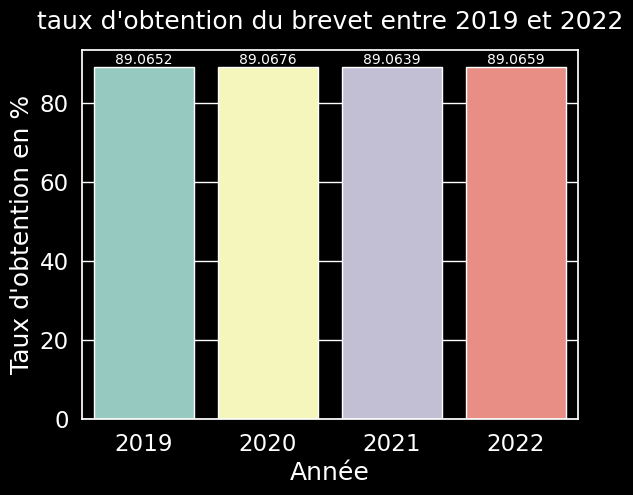

In [36]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y="taux_de_reussite_g",ax=ax,estimator="sum",errorbar=None)
ax.set_title("taux d'obtention du brevet entre 2019 et 2022",pad=15)
ax.set_ylabel("Taux d'obtention en %")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

On a un taux stable de près de 90%.<br>
9 éléve sur 10. 

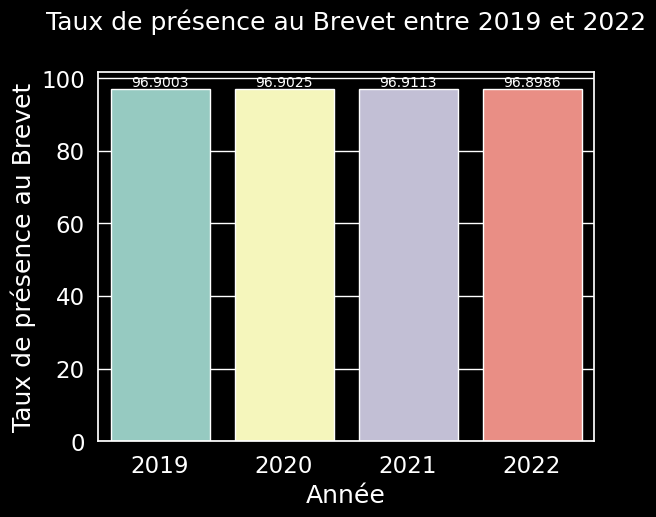

In [37]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y="part_presents_3eme_ordinaire_total",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Taux de présence au Brevet entre 2019 et 2022",pad=30)
ax.set_ylabel("Taux de présence au Brevet")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()


4% des élèves ne se pésentent pas à l'examen.

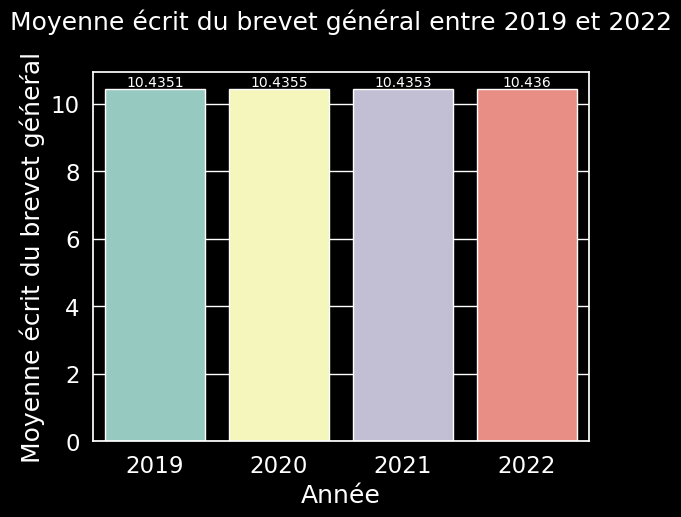

In [38]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y="note_a_l_ecrit_g",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Moyenne écrit du brevet général entre 2019 et 2022",pad=30)
ax.set_ylabel("Moyenne écrit du brevet géńeŕal")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

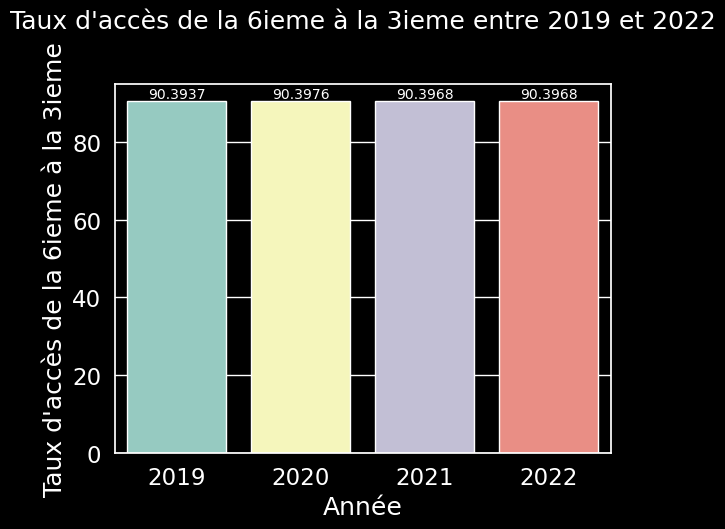

In [39]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y='taux_d_acces_6eme_3eme',ax=ax,estimator="sum",errorbar=None)
ax.set_title("Taux d'accès de la 6ieme à la 3ieme entre 2019 et 2022",pad=40)
ax.set_ylabel("Taux d'accès de la 6ieme à la 3ieme")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

Le taux d'accès de la 6 ieme à la 3ieme : Pourcentage d'éléve qui ont fait leurs scolarité entiere dans le college.<br>
Les redoublants, les déménagements, les changements du à une option indisponible dans le collège ne sont pas pris en compte dans cet indiquateur.<br>

Les éléves restent à 90% dans leurs établiseements.<br>

In [40]:
#nettoyage memoire
del france_college